In [1]:
import Pkg;
Pkg.activate(@__DIR__);
Pkg.instantiate()

  Activating environment at `~/tinympc-julia/state_constraints/Project.toml`


In [6]:
using ForwardDiff
using LinearAlgebra
using StaticArrays
using SparseArrays
using ControlSystems
using BlockDiagonals

using Plots
using Printf

include("../quaternion-stuff.jl")

E (generic function with 1 method)

In [7]:
# Quadrotor parameters
m = 0.035
ℓ = 0.046/sqrt(2)
J = [16.6e-6 0.83e-6 0.72e-6;
    0.83e-6 16.6e-6 1.8e-6;
    0.72e-6 1.8e-6 29.3e-6];
gravity = 9.81
thrustToTorque = 0.0008
scale = 65535
kt = 2.245365e-6*scale # u is PWM in range [0...1]
km = kt*thrustToTorque #4.4733e-8

#Goal state
uhover = (m*gravity/kt/4)*ones(4) # m = 30g and max thrust = 60g
# uhover = [0.701, 0.701, 0.832, 0.732]
rg = [0.0; 0; 0.0]
qg = [1.0; 0; 0; 0]
vg = zeros(3)
ωg = zeros(3)
xg = [rg; qg; vg; ωg];

In [8]:
function quad_dynamics(x,u)
    r = x[1:3]
    q = x[4:7]/norm(x[4:7]) #normalize q just to be careful
    v = x[8:10]
    ω = x[11:13]
    Q = qtoQ(q)
    
    ṙ = v
    q̇ = 0.5*L(q)*H*ω
    
    b = 1/m
    
    v̇ = [0; 0; -gravity] + (1/m)*Q*[zeros(2,4); kt*ones(1,4)]*u 
    
    ω̇ = J\(-hat(ω)*J*ω + [-ℓ*kt -ℓ*kt ℓ*kt ℓ*kt; -ℓ*kt ℓ*kt ℓ*kt -ℓ*kt; -km km -km km]*u)
    
    return [ṙ; q̇; v̇; ω̇]
end
function quad_dynamics_rk4(x,u,h)
    #RK4 integration with zero-order hold on u
    f1 = quad_dynamics(x, u)
    f2 = quad_dynamics(x + 0.5*h*f1, u)
    f3 = quad_dynamics(x + 0.5*h*f2, u)
    f4 = quad_dynamics(x + h*f3, u)
    xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    xn[4:7] = xn[4:7]/norm(xn[4:7]) #re-normalize quaternion
    return xn
end

quad_dynamics_rk4 (generic function with 1 method)

In [26]:
# Cost weights
max_dev_x = [0.1; 0.1; 0.1; 0.5; 0.5; 0.05;  0.5; 0.5; 0.5;  0.7; 0.7; 0.5]
max_dev_u = [0.02; 0.02; 0.02; 0.02]
Q = diagm(1 ./(max_dev_x.^2))
R = diagm(1 ./(max_dev_u.^2))
Qf = Q

ρ = 5
R̃ = R + ρ*I;
Q̃ = Q + ρ*I;
Q̃f = Qf + ρ*I;
;

# Compute continuous time K
Ac = ForwardDiff.jacobian(x->quad_dynamics(x,uhover),xg)
Bc = ForwardDiff.jacobian(u->quad_dynamics(xg,u),uhover);
Ãc = Array(E(qg)'*Ac*E(qg))
B̃c = Array(E(qg)'*Bc);

Kc = lqr(Continuous, Ãc, B̃c, Q̃, R̃)

hs = 1 ./[1, 25, 50, 100, 250, 500, 1000, 3000, 10000]
errs = zeros(length(hs))
for (i, h) in enumerate(hs)
    # Compute K for time step h
    A = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,uhover,h),xg)
    B = ForwardDiff.jacobian(u->quad_dynamics_rk4(xg,u,h),uhover);
    Ã = Array(E(qg)'*A*E(qg))
    B̃ = Array(E(qg)'*B);

    K = dlqr(Ã, B̃, Q̃, R̃)

    err = maximum(abs.(Kc-K))
    display(err)
    errs[i] = err
end

0.42967118729823633

0.20652448930468317

0.12575532252906613

0.06954710397283193

0.02953933530631342

0.015065198926062173

0.007607234916434724

0.002552416883556785

0.0007669287207580089

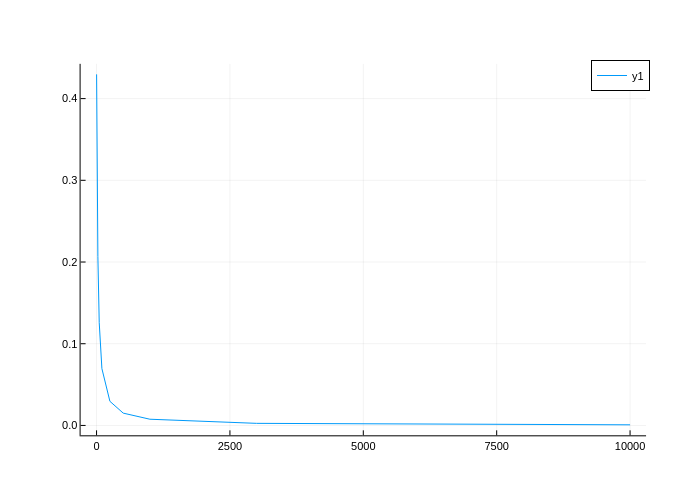

In [35]:
plotlyjs()
display(plot(1 ./hs, errs))

Use CVXgen and OSQP to benchmark on a few microcontrollers

Teensy, STM32F401 (Nucleo f401re), STM32F405

Look at ALTRO-C paper for comparison plots

    Plot problem dimension (state and control) vs iteration solve time

    Plot different problems vs number of solves
    
    Varying horizon isn't that interesting because time complexity is linear wrt horizon

How to time microcontroller error